In [1]:
import pandas as pd
import numpy as np
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [32]:
df = pd.read_csv('data/data.csv', encoding='latin-1')
df = df[['Prod_Budget', 'Rated', 'Genre', 'Total_Torrents']]
print(len(df))
print(df.head())

1653
   Prod_Budget  Rated                         Genre  Total_Torrents
0  425000000.0  PG-13    Action, Adventure, Fantasy          1450.0
1  300000000.0  PG-13   Action, Adventure, Thriller           647.0
2  275000000.0  PG-13      Action, Adventure, Drama           861.0
3  275000000.0  PG-13     Action, Adventure, Sci-Fi           723.0
4  260000000.0     PG  Animation, Adventure, Comedy           563.0


In [31]:
# unique list of grouped genres as a string
unq_genres = df['Genre'].unique()
unq_genres = unq_genres.tolist()

# unique list of grouped genres as a list of genres
lst_grp_genres = []
for lst in unq_genres:
    temp = []
    for genre in lst.split(','):
         temp.append(genre)
    lst_grp_genres.append(temp)

#print(len(unq_genres))
#print(unq_genres[:10])

In [29]:
# unique list of individual genres
ind_genre = set()

for lst in unq_genres:
    for genre in lst.split(','):
        ind_genre.add(genre.strip())
ind_genre = sorted(ind_genre)

#print(len(ind_genre))
#print(ind_genre)

In [30]:
# dictionary - count of genre occurences
count = defaultdict(lambda:0)

for genre in ind_genre:
    count[genre] = df.Genre.str.contains(genre).sum()

import operator
srt = sorted(count.items(), key=operator.itemgetter(1))
srt = srt[::-1]
#print(srt)

In [8]:
def split_to_array(ser):
    split_array = np.array(ser.strip().replace(',','').split(' '))
    return pd.Series(split_array)

genres = df.Genre.apply(split_to_array)
genres = pd.Series(genres.values.ravel()).dropna()
genres = genres.value_counts().sort_values(ascending=False)

In [9]:
def convert_frequency(ser, genres=genres):
    split_array = np.array(ser.strip().replace(',','').split(' '))
    genre = genres.loc[split_array].argmax()
    return genre

df['Genre_Single'] = df.Genre.apply(convert_frequency)
#df_test=df[['Genre','Genre_Single']]

# Select only significant values from dataframe

In [10]:
# select only genres of significance
genre = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama']
df_sub = df.loc[df['Genre_Single'].isin(genre)]

# select only genres of significance
ratings = ['PG-13', 'PG', 'G', 'R']
df_sub = df_sub.loc[df_sub['Rated'].isin(ratings)]

#df_sub['Genre_Single'].value_counts()
#df_sub['Rated'].value_counts()
df_sub.describe()

,Prod_Budget,Total_Torrents
count,1.486000e+03,1486.000000
mean,5.091483e+07,226.755047
std,4.523104e+07,201.882522
min,6.800000e+04,17.000000
25%,2.000000e+07,86.250000
50%,3.800000e+07,160.000000
75%,6.500000e+07,303.750000
max,4.250000e+08,1450.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cf50e48>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10ce46748>]], dtype=object)

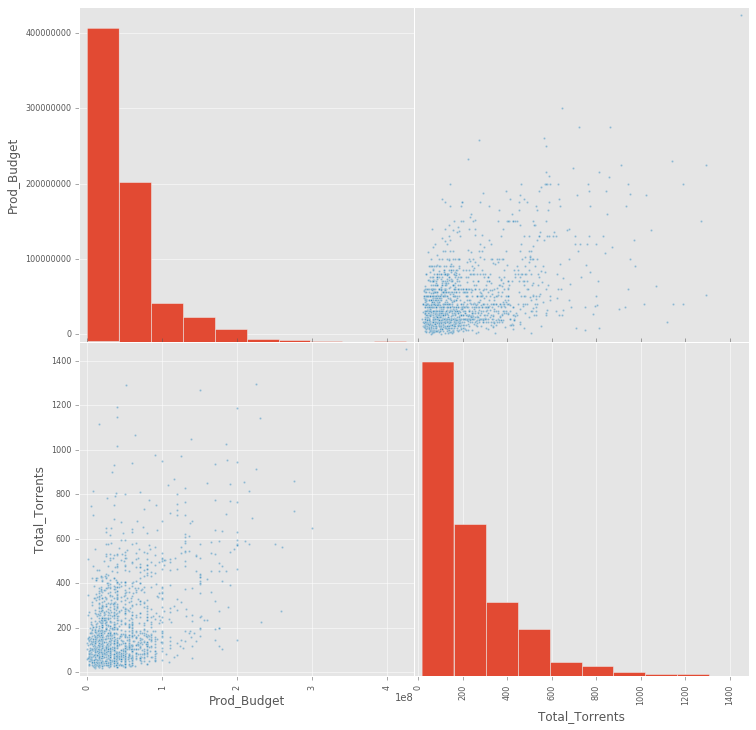

In [11]:
# Lets take a look at our entire model
plt.rcParams['figure.figsize'] = (12, 12)
pd.tools.plotting.scatter_matrix(df_sub)

In [12]:
from patsy import dmatrices

y, x = dmatrices('Total_Torrents ~ Prod_Budget + Genre_Single + Rated', data=df_sub, return_type='dataframe')

In [13]:
y.head()

,Total_Torrents
0,1450.0
1,647.0
2,861.0
3,723.0
4,563.0


In [14]:
x.head()

,Intercept,Genre_Single[T.Adventure],Genre_Single[T.Comedy],Genre_Single[T.Crime],Genre_Single[T.Drama],Rated[T.PG],Rated[T.PG-13],Rated[T.R],Prod_Budget
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,425000000.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,300000000.0
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,275000000.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,275000000.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,260000000.0


In [15]:
import statsmodels.api as sm

model = sm.OLS(y, x)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Total_Torrents   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     65.99
Date:                Wed, 13 Jul 2016   Prob (F-statistic):           1.22e-92
Time:                        17:16:55   Log-Likelihood:                -9768.2
No. Observations:                1486   AIC:                         1.955e+04
Df Residuals:                    1477   BIC:                         1.960e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                   191.6311     42.757      4.482      0.000       107.759   275.503
Genre_Single[T.Adventure]  -112.5564     31.569     -3.565      0.000      -174.482   -50.631
Genre_Single[T.Comedy]      -69.6419     13.592     -5.124      0.000       -96.303   -42.980
Genre_Single[T.Crime]      -107.7725     35.785     -3.012      0.003      -177.967   -37.578
Genre_Single[T.Drama]       -69.1198     12.763     -5.416      0.000       -94.155   -44.084
Rated[T.PG]                 -49.7366     40.724     -1.221      0.222      -129.619    30.146
Rated[T.PG-13]              -20.0642     40.320     -0.498      0.619       -99.156    59.027
Rated[T.R]                    8.0783     40.625      0.199      0.842       -71.611    87.768
Prod_Budget                2.085e-06    1.1e-07     18.995      0.000      1.87e-06   2.3e-06
==============================================================================
Omnibus:                      466.409   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1690.385
Skew:                           1.508   Prob(JB):                         0.00
Kurtosis:                       7.266   Cond. No.                     1.22e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
import statsmodels.formula.api as smf

results = smf.ols(formula='Total_Torrents ~ Prod_Budget + Genre_Single + Rated', data=df_sub,).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Total_Torrents   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     65.99
Date:                Wed, 13 Jul 2016   Prob (F-statistic):           1.22e-92
Time:                        17:16:55   Log-Likelihood:                -9768.2
No. Observations:                1486   AIC:                         1.955e+04
Df Residuals:                    1477   BIC:                         1.960e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                   191.6311     42.757      4.482      0.000       107.759   275.503
Genre_Single[T.Adventure]  -112.5564     31.569     -3.565      0.000      -174.482   -50.631
Genre_Single[T.Comedy]      -69.6419     13.592     -5.124      0.000       -96.303   -42.980
Genre_Single[T.Crime]      -107.7725     35.785     -3.012      0.003      -177.967   -37.578
Genre_Single[T.Drama]       -69.1198     12.763     -5.416      0.000       -94.155   -44.084
Rated[T.PG]                 -49.7366     40.724     -1.221      0.222      -129.619    30.146
Rated[T.PG-13]              -20.0642     40.320     -0.498      0.619       -99.156    59.027
Rated[T.R]                    8.0783     40.625      0.199      0.842       -71.611    87.768
Prod_Budget                2.085e-06    1.1e-07     18.995      0.000      1.87e-06   2.3e-06
==============================================================================
Omnibus:                      466.409   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1690.385
Skew:                           1.508   Prob(JB):                         0.00
Kurtosis:                       7.266   Cond. No.                     1.22e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
model.score(x, y)

0.26330883296557606

In [19]:
model.coef_

array([[  0.00000000e+00,  -1.12556447e+02,  -6.96419000e+01,
         -1.07772527e+02,  -6.91198330e+01,  -4.97366343e+01,
         -2.00642174e+01,   8.07825376e+00,   2.08472953e-06]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10fd42e10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10fe151d0>]], dtype=object)

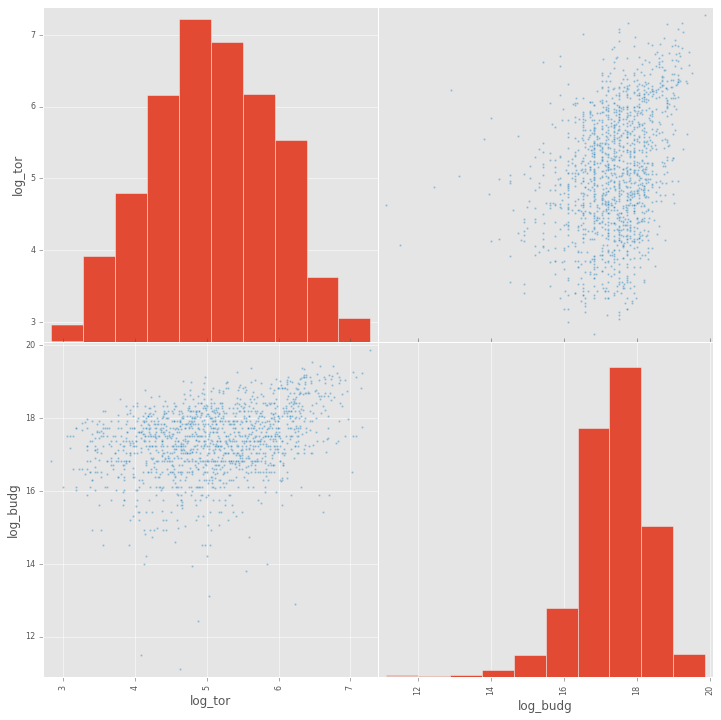

In [20]:
df_sub['log_tor']=np.log(df_sub.Total_Torrents)
df_sub['log_budg']=np.log(df_sub.Prod_Budget)

trans=df_sub[['log_tor','log_budg']]
pd.tools.plotting.scatter_matrix(trans)

---
# Log Transform

In [21]:
y, x = dmatrices('log_tor ~ log_budg + Genre_Single + Rated', data=df_sub, return_type='dataframe')
x.head()

,Intercept,Genre_Single[T.Adventure],Genre_Single[T.Comedy],Genre_Single[T.Crime],Genre_Single[T.Drama],Rated[T.PG],Rated[T.PG-13],Rated[T.R],log_budg
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.867600
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.519293
2,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,19.432282
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.432282
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,19.376192


In [22]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)

model.score(x,y)

0.15401709075025238

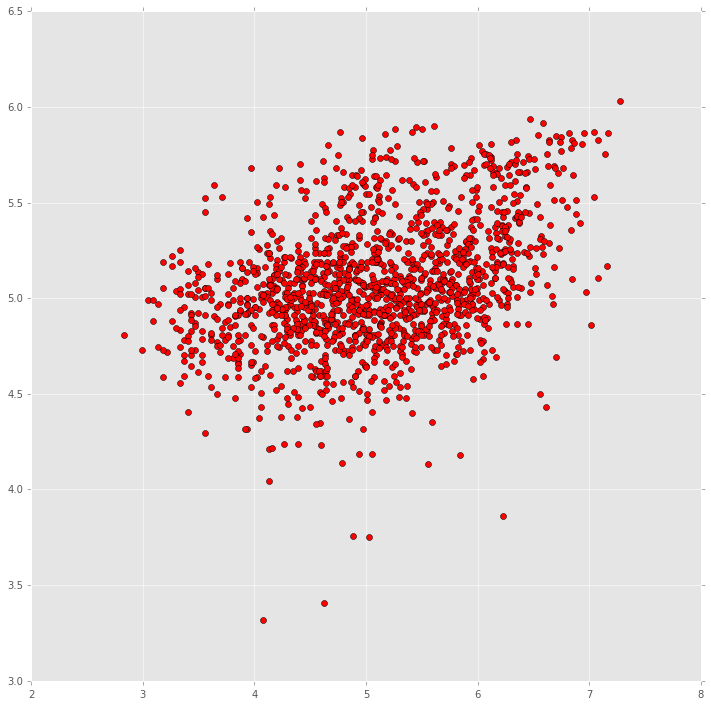

In [23]:
_ = plt.plot(y, model.predict(x), 'ro')

In [24]:
from sklearn import cross_validation as cv
from sklearn import metrics

x_train, x_test, y_train, y_test = cv.train_test_split(x,y,test_size=0.333,random_state=1234)

model = LinearRegression().fit(x_train, y_train)

In [25]:
metrics.mean_squared_error(y_train,model.predict(x_train))

0.62681209662604598

In [26]:
model.score(x_train, y_train)

0.15952183267374409

In [27]:
metrics.mean_squared_error(y_test,model.predict(x_test))

0.58965122655413671

In [28]:
# reset x, y otherwise errors occur
y, x = dmatrices('log_tor ~ log_budg + Genre_Single', data=df_sub, return_type='dataframe')

from sklearn.cross_validation import KFold
kf = KFold(len(df_sub), n_folds=10, shuffle=True)

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf2 = LinearRegression().fit(x.iloc[train_index], y.iloc[train_index])

clf2.score(x,y)

0.14544576153641164